# HybridAgent Visualization Notebook

This notebook provides comprehensive visualizations of the HybridAgent class, including:
1. **Agent Architecture**: Component relationships and data flow
2. **LangGraph Workflow**: Visual representation of the graph execution flow
3. **Live Agent Execution**: Real-time visualization of agent processing
4. **Component Analysis**: Deep dive into individual components

The visualizations use the actual HybridAgent implementation without any mocking.


In [1]:
# Import required libraries
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import networkx as nx
import seaborn as sns
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.offline import init_notebook_mode, iplot
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, Any, List
import warnings
warnings.filterwarnings('ignore')

# Initialize plotly for notebook
init_notebook_mode(connected=True)

# Set up paths
project_root = Path.cwd()
sys.path.append(str(project_root))

# Import the HybridAgent and related components
from agent.graph_hybrid import HybridAgent, AgentState
from agent.dspy_signatures import (
    RequirementParser, Router, SQLGenerator, Synthesizer
)
from agent.rag.retrieval import RAGRetriever
from agent.sql.sqlite_tool import SQLiteInspector, SQLExecutor

print("All imports successful!")
print(f"Project root: {project_root}")


All imports successful!
Project root: /home/mohammed/Desktop/tech_projects/northwind_ai_workflow


## 1. Initialize HybridAgent

Let's initialize the real HybridAgent with the actual database and documents.


In [2]:
# Define paths
db_path = project_root / "data" / "northwind.sqlite"
docs_dir = project_root / "docs"

# Verify paths exist
print(f"Database exists: {db_path.exists()} - {db_path}")
print(f"Docs dir exists: {docs_dir.exists()} - {docs_dir}")

if docs_dir.exists():
    doc_files = list(docs_dir.glob("*.md"))
    print(f"Found {len(doc_files)} document files:")
    for doc in doc_files:
        print(f"  - {doc.name}")

# Initialize the HybridAgent
print("\nInitializing HybridAgent...")
try:
    agent = HybridAgent(
        db_path=str(db_path),
        docs_dir=str(docs_dir),
        model_name="phi3.5:3.8b-mini-instruct-q4_K_M"
    )
    print("HybridAgent initialized successfully!")
    
    # Get basic info about the agent
    print(f"\nAgent Components:")
    print(f"  - Database: {agent.db_path}")
    print(f"  - Documents: {agent.docs_dir}")
    print(f"  - Model: {agent.model_name}")
    print(f"  - RAG chunks: {len(agent.rag_retriever.get_all_chunks())}")
    print(f"  - DB tables: {len(agent.sql_inspector.schema_cache)}")
    
except Exception as e:
    print(f"Error initializing agent: {e}")
    agent = None


Database exists: True - /home/mohammed/Desktop/tech_projects/northwind_ai_workflow/data/northwind.sqlite
Docs dir exists: True - /home/mohammed/Desktop/tech_projects/northwind_ai_workflow/docs
Found 4 document files:
  - product_policy.md
  - kpi_definitions.md
  - marketing_calendar.md
  - catalog.md

Initializing HybridAgent...
Error loading schema: 12 validation errors for TableInfo
columns.0.not_null
  Input should be a valid string [type=string_type, input_value=False, input_type=bool]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
columns.0.default
  Input should be a valid string [type=string_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
columns.0.primary_key
  Input should be a valid string [type=string_type, input_value=True, input_type=bool]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
columns.1.not_null
  Input should be a vali

In [3]:
# Quick compile check for HybridAgent graph
try:
    from agent.graph_hybrid import HybridAgent

    # Ensure agent exists
    if 'agent' not in globals() or agent is None:
        agent = HybridAgent(
            db_path=str(db_path),
            docs_dir=str(docs_dir),
            model_name="phi3.5:3.8b-mini-instruct-q4_K_M"
        )

    print("Compiling graph...")
    compiled_graph = agent.graph.compile()
    print("\u2713 Graph compiled successfully.")

    # Try to introspect compiled graph structure
    try:
        g = compiled_graph.get_graph()
        try:
            nodes = list(g.nodes())
            edges = list(g.edges())
            print(f"Nodes ({len(nodes)}): {nodes}")
            print(f"Edges ({len(edges)}): {edges}")
        except Exception:
            print("Compiled graph obtained, but node/edge introspection not supported in this version.")
    except Exception as e:
        print(f"get_graph failed: {e}")
except Exception as e:
    import traceback
    print("Graph compilation failed:")
    print(repr(e))
    traceback.print_exc()


Compiling graph...
✓ Graph compiled successfully.
Compiled graph obtained, but node/edge introspection not supported in this version.


## 2. Component Architecture Visualization

Let's pull the graph architecture from the initialized agent then visualize the overall architecture and relationships between components.

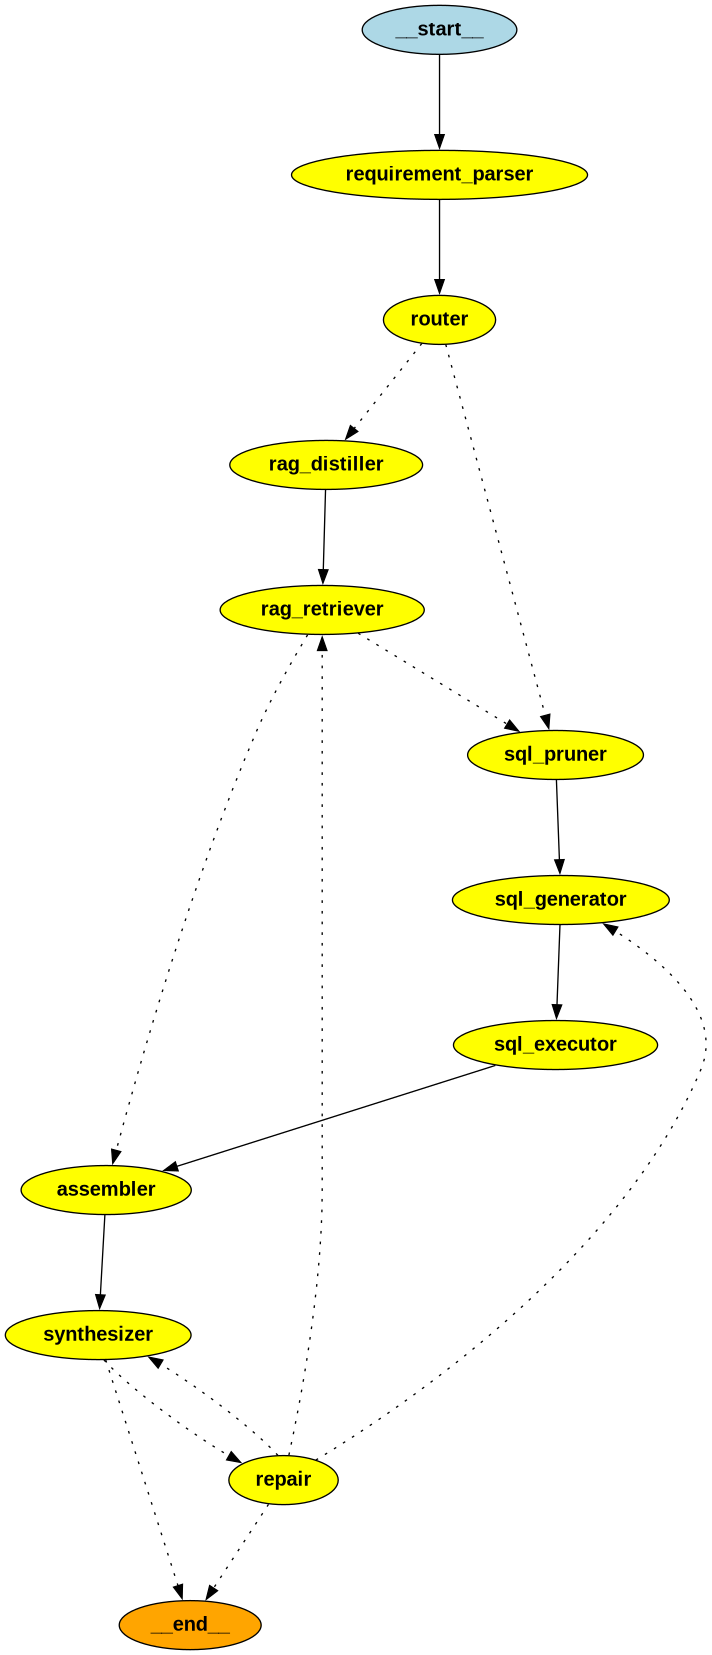

Graph visualization generated using built-in renderer.


In [4]:
# Built-in-only graph visualization (no manual fallbacks)
from IPython.display import Image, display

if 'agent' not in globals() or agent is None:
    raise RuntimeError("Agent not initialized. Run the initialization cell first.")

compiled_graph = agent.graph.compile()

# Resolve a renderable graph object depending on langgraph version
graph_obj = None
if hasattr(compiled_graph, 'get_graph'):
    try:
        graph_obj = compiled_graph.get_graph()
    except Exception as e:
        print(f"get_graph failed: {e}")
        graph_obj = None

if graph_obj is None:
    # Some versions expose draw_* on the compiled graph itself
    graph_obj = compiled_graph

errors = []
img = None

# 1) Try Graphviz PNG
if hasattr(graph_obj, 'draw_png'):
    try:
        img = graph_obj.draw_png()
    except Exception as e:
        errors.append(f"draw_png: {e}")

# 2) Try Mermaid PNG using different draw methods
if img is None and hasattr(graph_obj, 'draw_mermaid_png'):
    MermaidDrawMethod = None
    try:
        from langgraph.graph.render import MermaidDrawMethod  # newer
    except Exception:
        try:
            from langgraph.graph.graph import MermaidDrawMethod  # older
        except Exception:
            MermaidDrawMethod = None

    # Prefer headless local first, then server fallback
    for method in ([getattr(MermaidDrawMethod, 'PYPPETEER', None),
                    getattr(MermaidDrawMethod, 'SERVER', None),
                    None]):
        if img is not None:
            break
        try:
            if method is None:
                img = graph_obj.draw_mermaid_png()
            else:
                img = graph_obj.draw_mermaid_png(draw_method=method)
        except Exception as e:
            errors.append(f"draw_mermaid_png({method}): {e}")

if img is None:
    detail = " | ".join(errors) if errors else "unknown error"
    raise RuntimeError(f"Built-in graph rendering failed. Tried Graphviz and Mermaid. Details: {detail}")

display(Image(img))
print("Graph visualization generated using built-in renderer.")
